In [2]:
%pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from collections import defaultdict
from calendar import monthrange
from datetime import datetime, timedelta

In [4]:
# Set names
dsnNames = ["DSN1", "DSN2", "DSN3"]
alts = [100, 500, 900, 1300]
incs = [0  , 30 , 60 , 90  ]

In [5]:
# Load data
data = {dsnName: {alt: {inc: [] for inc in incs} for alt in alts} for dsnName in dsnNames}
for dsnName in dsnNames:
    for alt in alts:
        for inc in incs:

            # filename
            satName = "SAT-Mars-alt{}-inc{}".format(alt, inc)
            file_name = "access_int_1_{}_to_{}.csv".format(dsnName, satName)

            # load file
            with open(file_name, newline='') as csvfile:
                reader = csv.reader(csvfile)
                data_started = False
                
                for row in reader:
                    
                    # skip header
                    if not data_started:
                        if row and row[0].startswith('Access'):
                            data_started = True
                    else:
                        # load line
                        data[dsnName][alt][inc].append(row)

In [6]:
# Function to convert EpSec to datetime
def convert_epsec_to_datetime(epsec):
    start_date = datetime(2025, 1, 1)
    return start_date + timedelta(seconds=epsec)

# Speed of light in km/s
speed_of_light = 299792

In [7]:
# Plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

sns.set()
#palette = sns.color_palette("husl", 2)
palette = sns.color_palette()

# Timeline Dual Range/OWLT and DSN Participation

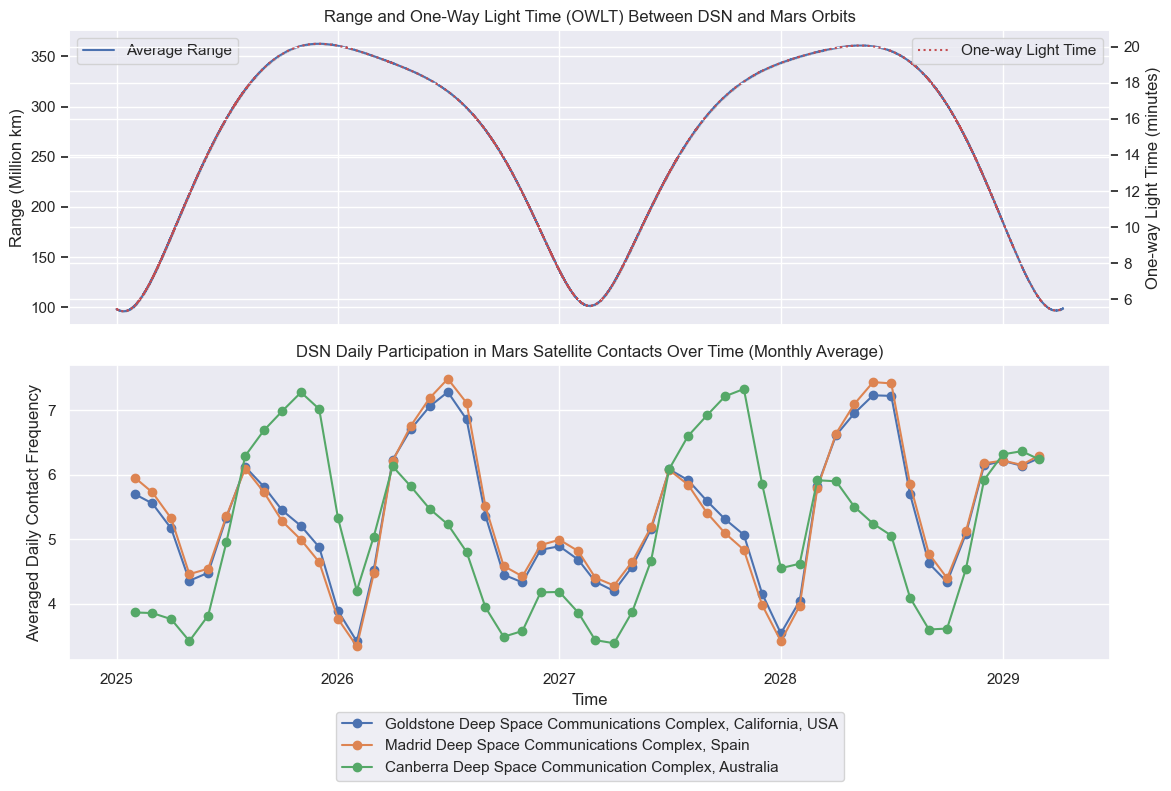

In [15]:
# Initialize lists to store the aggregated data
time_points = []
average_ranges = []
min_ranges = []
max_ranges = []

# Collect all range values for each time point
ranges_at_each_time_point = {}

for dsnName in dsnNames:
    for alt in alts:
        for inc in incs:
            for row in data[dsnName][alt][inc]:
                time = convert_epsec_to_datetime(float(row[1]))
                range_km = float(row[4]) / 1e6  # convert to million kilometers

                if time not in ranges_at_each_time_point:
                    ranges_at_each_time_point[time] = []
                ranges_at_each_time_point[time].append(range_km)

# Calculate average, min, and max for each time point
for time, ranges in sorted(ranges_at_each_time_point.items()):
    time_points.append(time)
    average_ranges.append(np.mean(ranges))
    min_ranges.append(min(ranges))
    max_ranges.append(max(ranges))

#############################################

# Function to get the number of days in a month
def days_in_month(year, month):
    return monthrange(year, month)[1]

# Function to convert EpSec to datetime and start of the week
def convert_to_start_of_week(epsec):
    date = convert_epsec_to_datetime(epsec)
    start_of_week = date - timedelta(days=date.weekday())
    # start_of_week = date - datetime.timedelta(days=date.weekday())  # Adjust to the start of the week
    return start_of_week

# Initialize a dictionary to hold the contact counts per DSN over time
dsn_daily_contact_counts = defaultdict(lambda: defaultdict(float))

# Initialize a dictionary to hold the contact counts per DSN over time
dsn_weekly_contact_counts = defaultdict(lambda: defaultdict(float))

number_of_combinations = len(alts) * len(incs)  # 4 altitudes * 4 inclinations = 16 combinations

# Assuming data is loaded 
for dsnName in dsnNames:
    for alt in alts:
        for inc in incs:
            for row in data[dsnName][alt][inc]:
                # Extract the start time and convert to datetime object
                start_time = convert_epsec_to_datetime(float(row[1]))
                year_month = start_time.strftime('%Y-%m')
                year, month = map(int, year_month.split('-'))
                # Increment the count for the DSN site for the day of the contact
                # Divide by number of days in the month and number of alt/inc combinations
                dsn_daily_contact_counts[dsnName][year_month] += (1 / days_in_month(year, month)) / number_of_combinations

                # # Extract the start time and convert to datetime object
                # start_time = convert_epsec_to_datetime(float(row[1]))
                # date_key = start_time.date()  # Use just the date for daily granularity
                # # Increment the count for the DSN site for the day of the contact
                # # Since we're counting by day, there's no need to divide by the number of days in the month
                # dsn_daily_contact_counts[dsnName][date_key] += 1 / number_of_combinations

                # # Extract the start time and convert to the start of the week datetime object
                # start_of_week = convert_to_start_of_week(float(row[1]))
                # # Increment the count for the DSN site for the week of the contact
                # # Divide by number of alt/inc combinations
                # dsn_weekly_contact_counts[dsnName][start_of_week] += 1 / number_of_combinations

# Sort the weeks and exclude the first and last week
weeks_sorted = sorted(dsn_weekly_contact_counts[dsnNames[0]].keys())[1:-1]

# # Generate a list of all dates in the range of the data for plotting
# start_date = min(min(dsn_daily_contact_counts[dsn].keys()) for dsn in dsnNames)
# end_date = max(max(dsn_daily_contact_counts[dsn].keys()) for dsn in dsnNames)
# date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# # Exclude the first and last days if they are not complete
# date_list = date_list[1:-1]

# Sort the months and exclude the first and last month
months_sorted = sorted(dsn_daily_contact_counts[dsnNames[0]].keys())[1:-1]

#############################################
# Initialize the figure with two subplots, sharing the X-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

#############################################
# First subplot: Average Range and One-way Light Time
# Plot average range and the shadowed area for min/max values
ax1.fill_between(time_points, min_ranges, max_ranges, color='gray', alpha=0.2)
ax1.plot(time_points, average_ranges, label='Average Range', color='b')
ax1.set_title("Range and One-Way Light Time (OWLT) Between DSN and Mars Orbits")  # Set title for ax1

# Formatting the primary y-axis (left)
ax1.set_ylabel('Range (Million km)')

# Creating the secondary y-axis (right) for the first subplot
ax1_2 = ax1.twinx()
one_way_light_time_min = [range_km * 1e6 / (speed_of_light * (60)) for range_km in average_ranges]
ax1_2.plot(time_points, one_way_light_time_min, label='One-way Light Time', color='r', linestyle=':')
ax1_2.set_ylabel('One-way Light Time (minutes)')

# Place the legend of ax1 inside the plot
ax1.legend(loc='upper left')
ax1_2.legend(loc='upper right')

# Formatting the x-axis for the first subplot
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# fig.autofmt_xdate()  # Rotation

#############################################
# Second subplot: DSN Daily Participation
# Plot DSN daily contact counts

dsn_full_names = {
    'DSN1': 'Goldstone Deep Space Communications Complex, California, USA',
    'DSN2': 'Madrid Deep Space Communications Complex, Spain',
    'DSN3': 'Canberra Deep Space Communication Complex, Australia'
}

for dsnName in dsnNames:
    counts_sorted = [dsn_daily_contact_counts[dsnName][month] for month in months_sorted]
    months_datetime = [datetime.strptime(month, '%Y-%m') for month in months_sorted]
    full_name = dsn_full_names[dsnName]  # Look up the full name
    ax2.plot(months_datetime, counts_sorted, marker='o', label=full_name)
# for dsnName in dsnNames:
#     counts_sorted = [dsn_daily_contact_counts[dsnName].get(date, 0) for date in date_list]
#     ax2.plot(date_list, counts_sorted, label=dsn_full_names[dsnName])
# for dsnName in dsnNames:
#     counts_sorted = [dsn_weekly_contact_counts[dsnName][week] for week in weeks_sorted]
#     ax2.plot(weeks_sorted, counts_sorted, label=dsn_full_names[dsnName])

# Formatting the second subplot
ax2.set_xlabel('Time')
ax2.set_ylabel('Averaged Daily Contact Frequency')
ax2.set_title('DSN Daily Participation in Mars Satellite Contacts Over Time (Monthly Average)')

# Adjust the bottom parameter to create more space for the legend
fig.subplots_adjust(bottom=0.2)

# Move the combined legend below the subplots with enough space to avoid overlap
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

# Apply tight_layout after adjustments
plt.tight_layout()

file_name = "stk-mars-backhaul-range-dsn-participation"
fig.savefig(file_name + '.png', dpi=300)  
fig.savefig(file_name + '.pdf')  

plt.show()


In [9]:
print(min(average_ranges), max(average_ranges))

96.07667615234864 362.60371272655163


In [10]:
print(min(one_way_light_time_min), max(one_way_light_time_min))

5.341296418425032 20.158627355330342


# Scatter Daily Duration/Frequency

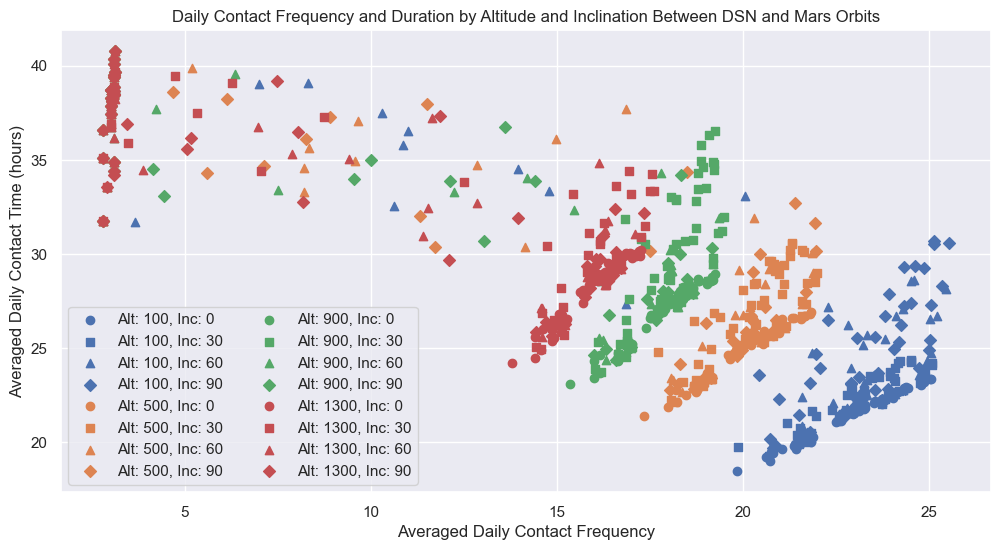

In [11]:
# Function to convert EpSec to datetime
def convert_epsec_to_datetime(epsec):
    start_date = datetime(2025, 1, 1)
    return start_date + timedelta(seconds=epsec)

# Initialize data structures for storing monthly frequency and duration
monthly_contact_frequency = {}
monthly_contact_duration = {}

for alt in alts:
    for inc in incs:
        monthly_contact_frequency[(alt, inc)] = {}
        monthly_contact_duration[(alt, inc)] = {}

# Aggregate data by month
for dsnName in dsnNames:
    for alt in alts:
        for inc in incs:
            for row in data[dsnName][alt][inc]:
                start_time = convert_epsec_to_datetime(float(row[1]))
                month = (start_time.year, start_time.month)
                duration = float(row[3])  # Duration in seconds

                if month not in monthly_contact_frequency[(alt, inc)]:
                    monthly_contact_frequency[(alt, inc)][month] = 0
                    monthly_contact_duration[(alt, inc)][month] = 0

                monthly_contact_frequency[(alt, inc)][month] += 1
                monthly_contact_duration[(alt, inc)][month] += duration

# Calculate daily averages
daily_avg_frequency = {}
daily_avg_duration = {}

for key in monthly_contact_frequency:
    daily_avg_frequency[key] = {}
    daily_avg_duration[key] = {}
    for month, freq in monthly_contact_frequency[key].items():
        days_in_month = 30  # Approximate number of days in a month
        daily_avg_frequency[key][month] = freq / days_in_month
        daily_avg_duration[key][month] = (monthly_contact_duration[key][month] / 3600) / days_in_month  # Convert to hours

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define markers for each inclination
markers = ['o', 's', '^', 'D']  # Example markers for 4 different inclinations

# Custom legend handling
legend_labels = []

# Plotting frequency and duration with distinct color and marker for each month
for i, alt in enumerate(alts):
    for j, inc in enumerate(incs):
        # Sort the months and exclude the first and last month
        sorted_months = sorted(daily_avg_frequency[(alt, inc)].keys())[1:-1]

        for month in sorted_months:
            freq = daily_avg_frequency[(alt, inc)][month]
            duration = daily_avg_duration[(alt, inc)][month]
            plot = ax1.scatter(freq, duration,
                               color=palette[i], marker=markers[j % len(markers)])
            # Add legend label only once for each alt and inc combination
            if month == sorted_months[0]:
                legend_labels.append(plot)

# Labeling and formatting
ax1.set_xlabel('Averaged Daily Contact Frequency')
ax1.set_ylabel('Averaged Daily Contact Time (hours)')
ax1.set_title('Daily Contact Frequency and Duration by Altitude and Inclination Between DSN and Mars Orbits')

# Create custom legends
ax1.legend(legend_labels, [f'Alt: {alt}, Inc: {inc}' for alt in alts for inc in incs], loc='lower left', ncol=2)

ax1.grid(True)

file_name = "stk-mars-backhaul-daily-frequency-duration-scatter"
fig.savefig(file_name + '.png', dpi=300)  
fig.savefig(file_name + '.pdf')  

plt.show()


# Timeline Dual Daily Frequency/Duration

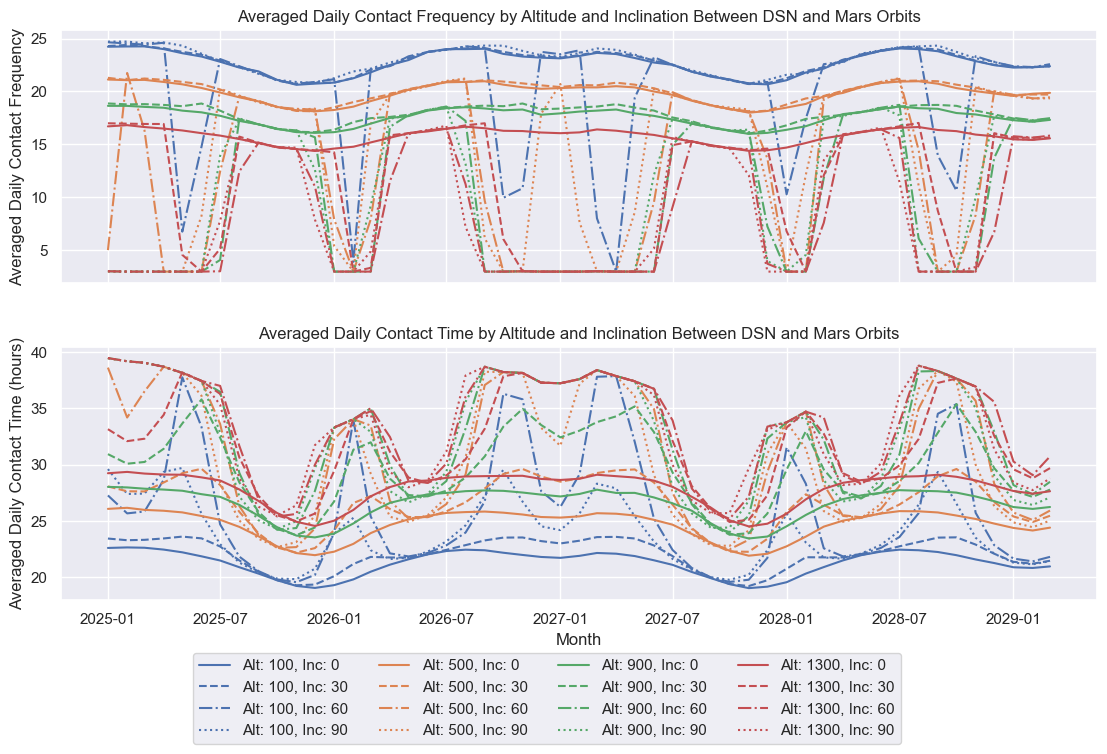

In [12]:
from calendar import monthrange
from copy import deepcopy

# Function to convert year and month to datetime for plotting
def convert_to_datetime(year_month):
    return datetime(year=year_month[0], month=year_month[1], day=1)

# Function to get the number of days in a month
def days_in_month(year, month):
    return monthrange(year, month)[1]

# Make a deep copy of the monthly data to store the daily data
daily_contact_frequency = deepcopy(monthly_contact_frequency)
daily_contact_duration = deepcopy(monthly_contact_duration)

# Update the copies to contain daily averages
for (alt, inc), months in daily_contact_frequency.items():
    for month, freq in months.items():
        num_days = days_in_month(month[0], month[1])
        daily_contact_frequency[(alt, inc)][month] = freq / num_days

for (alt, inc), months in daily_contact_duration.items():
    for month, duration in months.items():
        num_days = days_in_month(month[0], month[1])
        daily_contact_duration[(alt, inc)][month] = duration / (num_days)  # Convert to daily average in hours

# Initialize the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Define colors for each altitude and line styles for each inclination
line_styles = ['-', '--', '-.', ':']

# First subplot: Frequency
for i, alt in enumerate(alts):
    for j, inc in enumerate(incs):
        months = sorted(daily_contact_frequency[(alt, inc)].keys())[1:-1]
        freq_values = [daily_contact_frequency[(alt, inc)][month] for month in months]
        months = [convert_to_datetime(month) for month in months]

        # Frequency plot
        ax1.plot(months, freq_values, label=f'Alt: {alt}, Inc: {inc}',
                 color=palette[i], linestyle=line_styles[j % len(line_styles)])

# Second subplot: Duration
for i, alt in enumerate(alts):
    for j, inc in enumerate(incs):
        months = sorted(daily_contact_duration[(alt, inc)].keys())[1:-1]
        duration_values = [daily_contact_duration[(alt, inc)][month] / 3600 for month in months]
        months = [convert_to_datetime(month) for month in months]

        # Duration plot
        ax2.plot(months, duration_values, label=f'Alt: {alt}, Inc: {inc}',
                 color=palette[i], linestyle=line_styles[j % len(line_styles)])

# Labeling and formatting
ax2.set_xlabel('Month')  
ax1.set_ylabel('Averaged Daily Contact Frequency')
ax2.set_ylabel('Averaged Daily Contact Time (hours)')
ax1.set_title('Averaged Daily Contact Frequency by Altitude and Inclination Between DSN and Mars Orbits')
ax2.set_title('Averaged Daily Contact Time by Altitude and Inclination Between DSN and Mars Orbits')

# Adjust layout and create combined legend
fig.tight_layout(pad=3.0)
fig.subplots_adjust(bottom=0.2)  # Adjust the bottom to make space for the legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01))


file_name = "stk-mars-backhaul-frequency-duration-timeline"
fig.savefig(file_name + '.png', dpi=300)  
fig.savefig(file_name + '.pdf')  

plt.show()


In [13]:
# First subplot: Frequency
for i, alt in enumerate(alts):
    for j, inc in enumerate(incs):
        months = sorted(daily_contact_frequency[(alt, inc)].keys())[1:-1]
        freq_values = [daily_contact_frequency[(alt, inc)][month] for month in months]
        print ("frq:", alt, inc, min(freq_values), max(freq_values))
    

frq: 100 0 20.633333333333333 24.258064516129032
frq: 100 30 20.7 24.392857142857142
frq: 100 60 3.0 24.64516129032258
frq: 100 90 20.733333333333334 24.714285714285715
frq: 500 0 18.0 21.129032258064516
frq: 500 30 18.066666666666666 21.29032258064516
frq: 500 60 3.0 21.75
frq: 500 90 3.0 21.258064516129032
frq: 900 0 16.0 18.64516129032258
frq: 900 30 16.033333333333335 18.870967741935484
frq: 900 60 3.0 18.741935483870968
frq: 900 90 3.0 18.548387096774192
frq: 1300 0 14.387096774193548 16.821428571428573
frq: 1300 30 3.0 17.032258064516128
frq: 1300 60 3.0 16.548387096774192
frq: 1300 90 3.0 16.774193548387096


In [14]:
# Second subplot: Duration
for i, alt in enumerate(alts):
    for j, inc in enumerate(incs):
        months = sorted(daily_contact_duration[(alt, inc)].keys())[1:-1]
        duration_values = [daily_contact_duration[(alt, inc)][month] / 3600 for month in months]
        print ("dur:", alt, inc, min(duration_values), max(duration_values))

dur: 100 0 19.019632675923404 22.636098045634867
dur: 100 30 19.204787490737658 23.597156845878335
dur: 100 60 19.54928939814814 37.8530608518532
dur: 100 90 19.76029577956912 29.696909847670454
dur: 500 0 21.90048379629423 26.154514851190402
dur: 500 30 22.17013370370351 29.622623518518413
dur: 500 60 22.46972173835121 38.687521425925894
dur: 500 90 22.661739121863825 39.455056487455174
dur: 900 0 23.429704305556086 28.014343449820792
dur: 900 30 23.724637583333724 35.78228926851847
dur: 900 60 24.00017741935508 39.45505835125449
dur: 900 90 24.28034029569914 39.45505374551971
dur: 1300 0 24.501370111112102 29.344385208333385
dur: 1300 30 24.895059991038295 38.38630796595046
dur: 1300 60 25.18597661290398 39.455054283154105
dur: 1300 90 25.46007722222243 39.45505430107527
